# Part 1

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
#Share Specific Information
r = 0.08 #risk-free continuously compounded interest rate 
S0 = 100 #current share price 
v0 = 0.06
kappa = 9
theta = 0.06
sigma = 0.3
rho = -0.4

#Call Specific Information
K = 100
T = 1
k_log = np.log(K)

#Approximation Information

t_max = 30
N = 100

In [3]:
#Characteristic function code

a = sigma**2/2

def b(u):
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

In [4]:
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

#Integral calculations
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

#Call value
fourier_call_val = S0*(1/2 + first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
fourier_call_val

13.734895692109049

# Part 2

Assume that $\sigma(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$, where $\sigma = 0.3$ and $\gamma = 0.75$. Using the formula below, simulate paths for the underlying share using sample sizes of 1000, 2000, …, 50000. Perform monthly simulations for a period of a year. We can simulate the next step in a share price path using the following formula:
$$S_{t_{i+1}} = S_{t_i}e^{(r - \frac{\sigma^2 (t_i,t_{i+1})}{2})(t_{i+1}-t_i)+\sigma(t_i, t_{i+1})\sqrt{t_{i+1}-t_i}Z}$$
where $S_{ti}$ is the share price at time $t_i$, $\sigma(t_i, t_{i+1})$ is the volatility for the period $[t_i,t_{i+1}]$, r is the risk-free interest rate, and Z~N(0, 1)

Note that we are attempting to run simulations using the CEV model. However, while the CEV model assumes that volatility is a continuous function of time and share price, we are making a simplifying assumption that volatility is constant over each simulation period.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#from question
sigma_const = 0.3
gamma = 0.75

#assumption
r = 0.03
S0 = 100
T = 1
sample_sizes = range(1000, 50001, 1000)

timesteps = 12

First, we define our helper functions. The next_share_price function is used to calculate the evolution of the share price at t+1, from the share price at t. We generate the random variable Z from within this function. The effective sigma is also written as a function of the share price at t. 

Just for exploration purposes, we also added a varying_vol flag, to allow us to switch between a constant volatility and varying volatility. We use the initial stock price instead of the previous price when assuming a contant volatility.

The other function is the generate_share_price_path function. We first create an empty numpy array of shape (sample_size x timesteps+1). Note the addition of one element to the timestep, as the first element is equal to the initial stock price. We then iterate through each path, and each timestep, applying the next_share_price function against the previous share price. We then convert the result into a pandas DataFrame and return the results.

In [3]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, varying_vol = True):
    Z = stats.norm.rvs()
    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)
        
    return prev_price*np.exp((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z)


def generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps, varying_vol = True):
    result = np.empty(shape=(sample_size, T*(timesteps+1))) #One additional timestep row as first row is just the initial share price
    
    for i in range(sample_size):
        for j in range(T*(timesteps+1)):
            if j == 0:
                result[i][j] = S0
            else:
                result[i][j] = next_share_price(result[i][j-1],r,1/timesteps, sigma_const, gamma, varying_vol)

    result_df = pd.DataFrame(result)
    result_df = result_df.transpose()
                      
    return result_df



We first explore to see the impact of using sigma under the CEV assumption, compared with to the usual Black-Scholes model. As per the notes, when $\gamma = 1$, that is the standard Black-Scholes model.  We increase T to 10 periods, and use a smaller sample size of 20. When plotting both sample paths together, we notice that the price paths under the CEV model (plotted in red below) are less spread-out. This is because the adjustment to the volatility $((S_{ti})^{\gamma-1})$, starts out as less than 1 and gets smaller as the stock price increases, when gamma = 0.75 (from the formula $\sigma(t_i,t_{i+1}) = \sigma(S_{ti})^{\gamma-1}$).

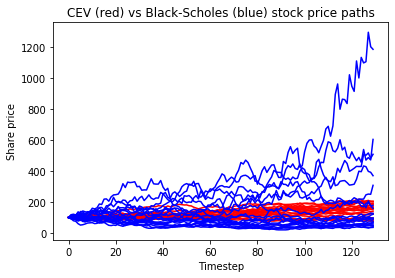

In [4]:
T = 10
sample_size = 20

share_price_path_cev = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps)
share_price_path_black_scholes = generate_share_price_path(S0, r, T, sigma_const, 1.0, sample_size, timesteps, varying_vol=False)

plt.plot(share_price_path_cev, label="CEV stock price paths", color='red')
plt.plot(share_price_path_black_scholes, label="Black-Scholes stock price paths", color='blue')
plt.xlabel("Timestep")
plt.ylabel("Share price")
plt.title("CEV (red) vs Black-Scholes (blue) stock price paths")
plt.show()

Next, we create a python dictionary called share_price_paths, to hold our results for part 2. The key of this dictionary would be the number of sample price paths, while the values would be the dataframes containing the price paths. We also track the rough processing time required at each step, by printing the time when each iteration completes.

In [5]:
import datetime

T = 1
sample_sizes = range(1000, 50001, 1000)

share_price_paths = {}

for sample_size in sample_sizes:
    share_val = generate_share_price_path(S0, r, T, sigma_const, gamma, sample_size, timesteps) 
     
    share_price_paths[sample_size] = share_val
    print("Updated for sample size {} at {}".format(sample_size, datetime.datetime.now().strftime('%H:%M')))


Updated for sample size 1000 at 11:56
Updated for sample size 2000 at 11:56
Updated for sample size 3000 at 11:56
Updated for sample size 4000 at 11:56
Updated for sample size 5000 at 11:56
Updated for sample size 6000 at 11:57
Updated for sample size 7000 at 11:57
Updated for sample size 8000 at 11:57
Updated for sample size 9000 at 11:57
Updated for sample size 10000 at 11:57
Updated for sample size 11000 at 11:57
Updated for sample size 12000 at 11:57
Updated for sample size 13000 at 11:58
Updated for sample size 14000 at 11:58
Updated for sample size 15000 at 11:58
Updated for sample size 16000 at 11:58
Updated for sample size 17000 at 11:58
Updated for sample size 18000 at 11:58
Updated for sample size 19000 at 11:58
Updated for sample size 20000 at 11:59
Updated for sample size 21000 at 11:59
Updated for sample size 22000 at 11:59
Updated for sample size 23000 at 11:59
Updated for sample size 24000 at 11:59
Updated for sample size 25000 at 12:00
Updated for sample size 26000 at 1

To display our output, we show the first 10 price paths generated by our iteration with 1000 samples:

In [6]:
share_price_paths[1000].iloc[:, 0:10]

,0,1,2,3,4,5,6,7,8,9
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,101.248185,96.378670,100.211832,100.211066,99.944135,98.206891,94.490511,95.406095,101.195325,98.364313
2,103.632804,94.770741,97.275241,104.244434,101.311506,94.156298,92.774139,95.088945,101.552742,96.383904
3,101.667793,97.198897,92.454079,101.588942,102.010909,100.916050,92.419948,97.760370,107.035706,92.496987
4,103.858195,102.926941,96.204907,99.577195,105.648092,97.796887,92.418448,98.015787,102.322439,92.119666
5,100.014856,103.683831,93.982791,96.548623,106.253937,98.166686,94.534224,95.936777,106.555001,91.945651
6,97.189428,109.187082,96.562722,99.178456,108.815071,97.252962,94.683374,94.768698,104.888941,87.741912
7,100.668694,110.339683,92.983490,98.255605,112.397262,97.274005,93.253312,90.073314,104.597875,88.095109
8,100.859993,113.316284,94.057874,97.811992,112.656408,96.582388,92.462989,92.434042,102.487538,85.793252
9,98.498816,111.371500,93.985646,97.375588,112.488065,96.202565,91.395726,95.143667,103.082196,86.015643


Next, we plot the price paths for the iteration with 1000 samples, 

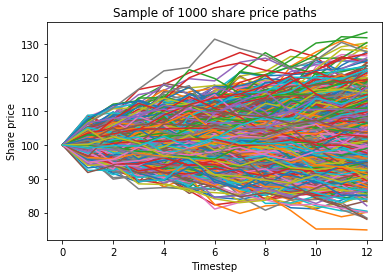

In [7]:
plt.plot(share_price_paths[1000])
plt.xlabel('Timestep')
plt.ylabel('Share price')
plt.title('Sample of 1000 share price paths')
plt.show()

# Part 3

# Part 4